In [1]:

import fastai
import object_detection_fastai

In [2]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import os
from bs4 import BeautifulSoup
import glob

In [4]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
import cv2
from PIL import ImageDraw, ImageFont, Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as immg
from matplotlib import patches, patheffects
from sklearn.model_selection import StratifiedKFold,KFold

In [245]:
def get_df(path):    
    files = glob.glob(path + '*.xml')
    files.sort()
    img_data = []
    for file in files:
        with open(file,'r') as f:
            data = f.read()
        xml_data = BeautifulSoup(data, "xml")
        filename = xml_data.filename.string

        img_data_meta = []
        imagenumber = 0
        for xy in xml_data.find_all('object'):
            img_data_meta.append(filename)
            name_tag = xy.find('name')
            img_data_meta.append(str(name_tag.contents[0]))
            img_data_meta.append(xy.pose.string)
            img_data_meta.append(imagenumber)
            img_data_meta.append(int(xy.xmin.string))
            img_data_meta.append(int(xy.ymin.string))
            img_data_meta.append(int(xy.xmax.string))
            img_data_meta.append(int(xy.ymax.string))
            img_data.append(img_data_meta)
            img_data_meta =[]
            imagenumber+=1

    df_data=pd.DataFrame(img_data,columns=['filename','label-name','pose','imagenumber','xmin','ymin','xmax','ymax'])
    return df_data

In [287]:
df_img_data = get_df('./data/train/')
df_img_data['width'] = df_img_data['xmax'] - df_img_data['xmin']
df_img_data['height'] = df_img_data['ymax'] - df_img_data['ymin']



In [288]:
df_test_data = get_df('./data/test/')
df_test_data['width'] = df_test_data['xmax'] - df_test_data['xmin']
df_test_data['height'] = df_test_data['ymax'] - df_test_data['ymin']

In [289]:
df_test_data.head()

,filename,label-name,pose,imagenumber,xmin,ymin,xmax,ymax,width,height
0,bio0000_frame0000016.jpg,bio,Unspecified,0,73,71,267,249,194,178
1,bio0000_frame0000016.jpg,bio,Unspecified,1,196,240,408,360,212,120
2,bio0000_frame0000041.jpg,bio,Unspecified,0,53,43,243,244,190,201
3,bio0000_frame0000041.jpg,bio,Unspecified,1,150,235,393,360,243,125
4,bio0000_frame0000043.jpg,bio,Unspecified,0,47,39,238,240,191,201


In [290]:
df_img_data.head()
len(df_img_data)

17395

In [275]:
def show_img(im, figsize=None,ax = None):
    if not ax: fig,ax =plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [276]:
def draw_outline(o,lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw,foreground='black'),
                        patheffects.Normal()])

In [277]:
def draw_rect(ax,xy,wd,ht):
    patch = ax.add_patch(patches.Rectangle(xy,wd,ht,fill = False,edgecolor='white',lw=2))
    draw_outline( patch,4)

In [278]:
def draw_text(ax,x,y,txt,sz=14):
    text = ax.text(x,y,txt,verticalalignment='top'
                   ,color='white',fontsize=sz,weight='bold')
    draw_outline(text,1)

In [337]:
def show_labeled_img(df,filename):
    df_filtered = df[df['filename'] == filename]
    im = cv2.imread('./data/train/%s'%(filename))
    ax = show_img(im,figsize=(8,8))
    for i in range(len(df_filtered.index.values)):
        xy = (df_filtered.iloc[i,4],df_filtered.iloc[i,5])
        wd = df_filtered.iloc[i,8]
        ht = df_filtered.iloc[i,9]
        draw_rect(ax,xy,wd,ht)
        draw_text(ax,df_filtered.iloc[i,4],df_filtered.iloc[i,5],df_filtered.iloc[i,1])

    #xy = (df_img_data.iloc[1,4],df_img_data.iloc[1,5])
    #wd = df_img_data.iloc[1,8]
    #ht = df_img_data.iloc[1,9]
    #draw_rect(ax,xy,wd,ht)
    #draw_text(ax,df_img_data.iloc[1,4],df_img_data.iloc[1,5],df_img_data.iloc[1,1])

In [280]:
flnm_grps = df_img_data.filename.unique()
grp_img_data = df_img_data.groupby('filename')

flnm_grps_test = df_test_data.filename.unique()
grp_test_data = df_test_data.groupby('filename')



In [281]:
flnm_grps_test

array(['bio0000_frame0000016.jpg', 'bio0000_frame0000041.jpg', 'bio0000_frame0000043.jpg', 'bio0000_frame0000073.jpg',
       ..., 'obj1672_frame0000213.jpg', 'obj1672_frame0000238.jpg', 'obj1672_frame0000242.jpg',
       'obj1672_frame0000262.jpg'], dtype=object)

In [314]:
size = 480
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)],ratios=[0.5,1,2],
                        scales=[0.35, 0.55, 0.75, 1, 1.25, 1.45])
len(anchors)

24480

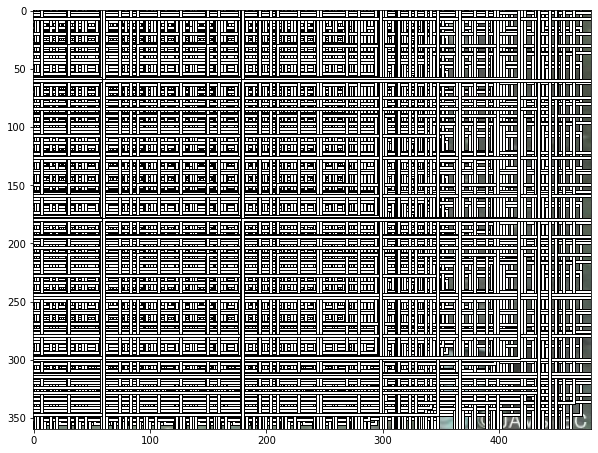

In [315]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(im)
for i, bbox in enumerate(anchors[6000:]):
    bb = bbox.numpy()
    x = (bb[0]) * size / 2 
    y = (bb[1]) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [[x,y],w,h]
    draw_rect(ax,[x,y],w,h)

In [316]:
xy_tmp = grp_img_data.get_group(flnm_grps[5719])[['xmin','ymin','width','height']]

In [384]:
#bioinbox = {}
#from tqdm.notebook import tqdm
for i in tqdm(range(len(flnm_grps))):
    xy_tmp = grp_img_data.get_group(flnm_grps[i])[['ymin','xmin','ymax','xmax']]
    label_tmp = grp_img_data.get_group(flnm_grps[i])[['label-name']]
    list_xy_an = [list(xy_tmp.iloc[x,:4]) for x in range(len(xy_tmp.index.values))]
    list_label = [label_tmp.loc[x,'label-name'] for x in label_tmp.index.values]
    list_xy_an = [list_xy_an,list_label]
    list_xy_an
    bioinbox[flnm_grps[i]] = list_xy_an


 

    

  0%|          | 0/5720 [00:00<?, ?it/s]

In [385]:
bioinbox['obj1672_frame0000258.jpg']

[[[195, 1, 270, 87], [56, 189, 96, 257]], ['rov', 'bio']]

In [386]:
df_flnm_grps = pd.DataFrame(flnm_grps,columns=['filename'])
df_flnm_grps_test = pd.DataFrame(flnm_grps_test,columns=['filename'])

In [387]:
path = Path('./data')
labels_func = lambda x : bioinbox[Path(x).name]
ts = (ObjectItemList.from_folder("./data/test/"))

In [388]:
data = (ObjectItemList.from_folder("./data/train/")
        .split_by_rand_pct(0.2)
        .label_from_func(labels_func)
        .transform(size=480)
        .add_test(ts)
        .databunch(bs=10,collate_fn=bb_pad_collate)
       )

/Users/varekai/opt/anaconda3/envs/pyODF37/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


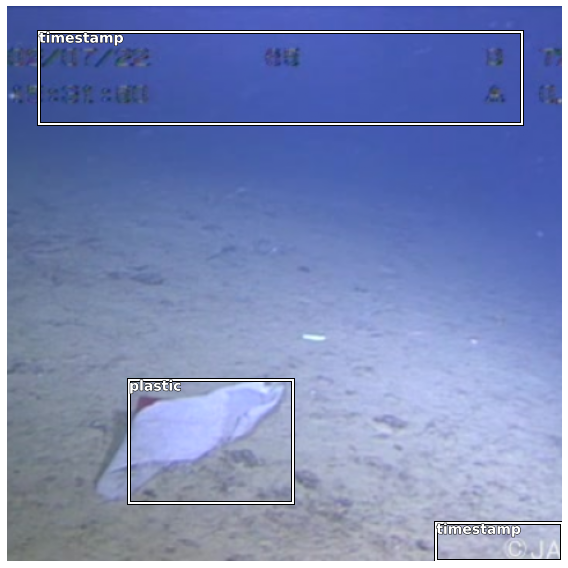

In [390]:
data.show_batch(1, figsize = (8,8), ds_type = DatasetType.Valid)

In [360]:
df_img_data[(df_img_data['label-name'] == 'timestamp')]

,filename,label-name,pose,imagenumber,xmin,ymin,xmax,ymax,width,height
1900,obj0000_frame0000001.jpg,timestamp,Unspecified,0,44,25,130,57,86,32
1901,obj0000_frame0000001.jpg,timestamp,Unspecified,1,357,25,438,45,81,20
1902,obj0000_frame0000001.jpg,timestamp,Unspecified,2,380,340,480,359,100,19
1905,obj0000_frame0000002.jpg,timestamp,Unspecified,0,47,26,140,60,93,34
1906,obj0000_frame0000002.jpg,timestamp,Unspecified,1,356,23,438,48,82,25
...,...,...,...,...,...,...,...,...,...,...
16045,obj1629_frame0000082.jpg,timestamp,Unspecified,1,341,1,480,42,139,41
16047,obj1629_frame0000082.jpg,timestamp,Unspecified,3,372,251,477,270,105,19
16048,obj1629_frame0000084.jpg,timestamp,Unspecified,0,10,1,138,55,128,54
16049,obj1629_frame0000084.jpg,timestamp,Unspecified,1,336,4,475,41,139,37


In [361]:
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(5148, 572, 1144)

In [362]:
im = cv2.imread('./data/train/%s'%(df_img_data.iloc[1906,0]))

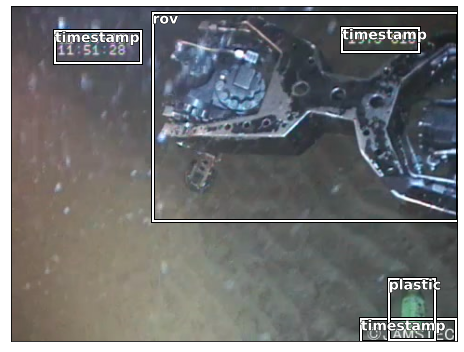

In [363]:
show_labeled_img(df_img_data,df_img_data.iloc[1906,0])

In [364]:
df_img_data.iloc[1906,0]

'obj0000_frame0000002.jpg'

In [365]:
bioinbox[df_img_data.iloc[1906,0]]

[[[47, 26, 140, 60],
  [356, 23, 438, 48],
  [376, 336, 478, 360],
  [152, 6, 480, 230],
  [406, 292, 456, 358]],
 ['timestamp', 'timestamp', 'timestamp', 'rov', 'plastic']]

In [366]:
df_img_data[df_img_data['filename']==df_img_data.iloc[1906,0]]

,filename,label-name,pose,imagenumber,xmin,ymin,xmax,ymax,width,height
1905,obj0000_frame0000002.jpg,timestamp,Unspecified,0,47,26,140,60,93,34
1906,obj0000_frame0000002.jpg,timestamp,Unspecified,1,356,23,438,48,82,25
1907,obj0000_frame0000002.jpg,timestamp,Unspecified,2,376,336,478,360,102,24
1908,obj0000_frame0000002.jpg,rov,Unspecified,3,152,6,480,230,328,224
1909,obj0000_frame0000002.jpg,plastic,Unspecified,4,406,292,456,358,50,66
